In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials

# Helper functions

## Main GuSTO function

In [41]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        println("GuSTO has been warm-started.")
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## Plotting functions

In [4]:
function plot_env_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter ==1 
            color = :darkblue
            plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
        elseif iter == length(X_all)
            color = :green
            plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
        else
            color = :blue
            plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
        end
        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_solution (generic function with 1 method)

In [5]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

In [6]:
function plot_three_comp(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 3
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter])
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
        end        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_three_comp (generic function with 2 methods)

## Reading and writing to files

In [7]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin_train = read(f["xMin_train"])
    yMin_train = read(f["yMin_train"])
    xRange_train = read(f["xRange_train"])
    yRange_train = read(f["yRange_train"])
    xMin_test = read(f["xMin_test"])
    yMin_test = read(f["yMin_test"])
    xRange_test = read(f["xRange_test"])
    yRange_test = read(f["yRange_test"])
    xMin_valid = read(f["xMin_valid"])
    yMin_valid = read(f["yMin_valid"])
    xRange_valid = read(f["xRange_valid"])
    yRange_valid = read(f["yRange_valid"])
    close(f)
    return (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end
    

getDataParamsFromHDF5 (generic function with 1 method)

## NN helper functions

In [8]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [9]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [10]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [11]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [12]:
function getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid)  = getDataParamsFromHDF5(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end

getNNStructure (generic function with 1 method)

In [13]:
function getNNPrediction(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) = getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin_train, xRange_train)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin_train, yRange_train)
    return (X_soln, U_soln)
end

getNNPrediction (generic function with 1 method)

## Get model on which data was collected and training done

In [14]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [15]:
function getModelWithCornerSpheres()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]
    model.obstacles = []
    obstacles = []
    obs = [[0.0,0.0,0.0], 6.0]
    push!(obstacles, obs)
    obs = [[5.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[3.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[5.0,3.0,0.0], 1.3]
    push!(obstacles, obs)
    model.obstacles = obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithCornerSpheres (generic function with 1 method)

In [16]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 100
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    println("Starting to solve GuSTO")
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    println("Converged: $isConverged")

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

# Warm-starting
- Find GuSTO solution (time it, plot it)
- Find NN prediction (time it, plot it) 
- Start GuSTO with NN prediction (time it, plot it)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 4.335972355 (5 iterations)
gusto_solve_time = 4.335972355
NN_solve_time = 0.004817785
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 6.415037848 (5 iterations)


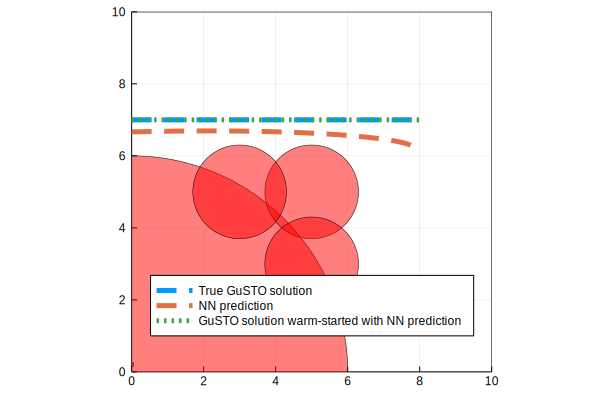

In [108]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 7.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 5.001513561 (5 iterations)
NN_solve_time = 0.020446938
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 4.589882906 (5 iterations)


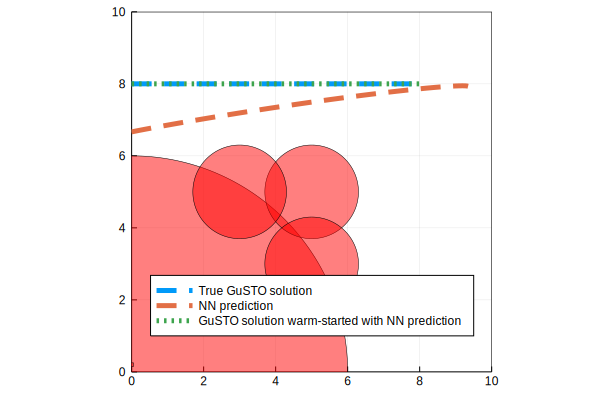

In [109]:
x_start= [0.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
gusto_solve_time = 5.287898476
NN_solve_time = 0.004951582
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
gusto_warm_solve_time = 6.091693398


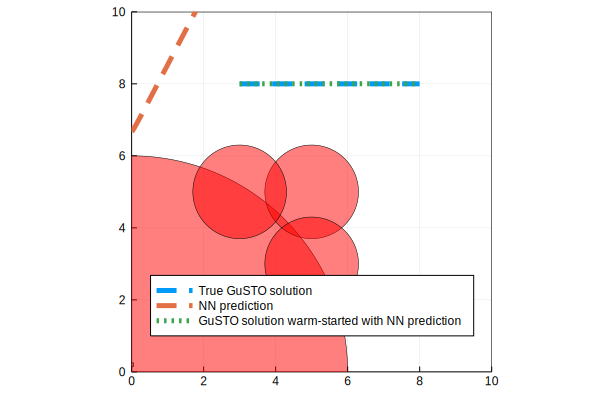

In [92]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
gusto_solve_time = 23.286085668
NN_solve_time = 0.007273393
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
gusto_warm_solve_time = 6.424369007


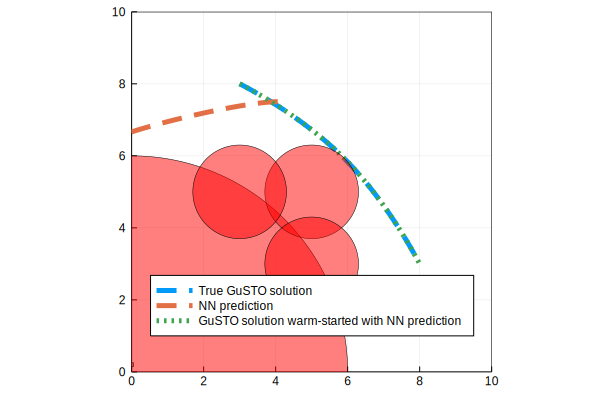

In [93]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
gusto_solve_time = 22.454962302
NN_solve_time = 0.008125375
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
gusto_warm_solve_time = 31.305461617


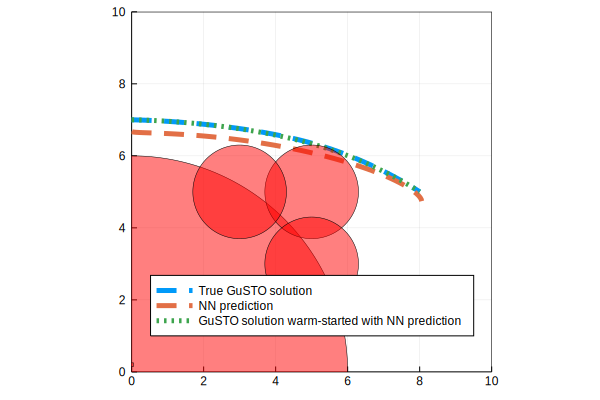

In [98]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 5.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 20.251445889 (20 iterations)
NN_solve_time = 0.012410183
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 5.934599804 (5 iterations)


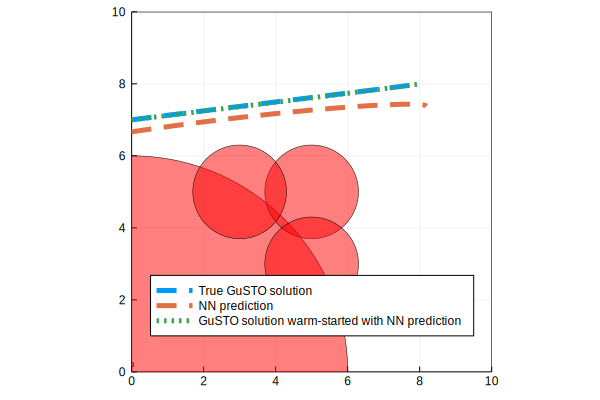

In [110]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 6.663636778 (7 iterations)
NN_solve_time = 0.007132755
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 5.988879422 (6 iterations)


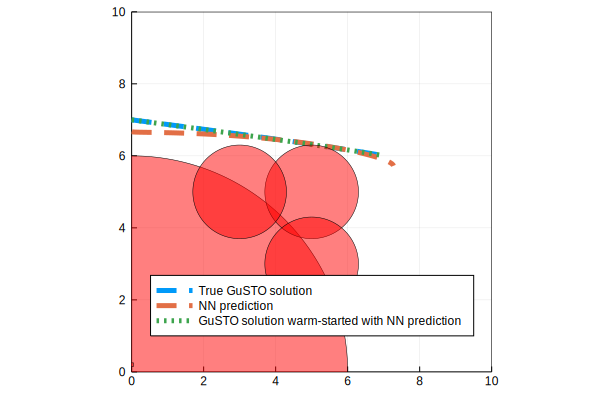

In [111]:
x_start= [0.0, 7.0, 0.0]
x_goal = [7.0, 6.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 3.65957181 (5 iterations)
NN_solve_time = 0.013351904
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 4.5763938 (5 iterations)


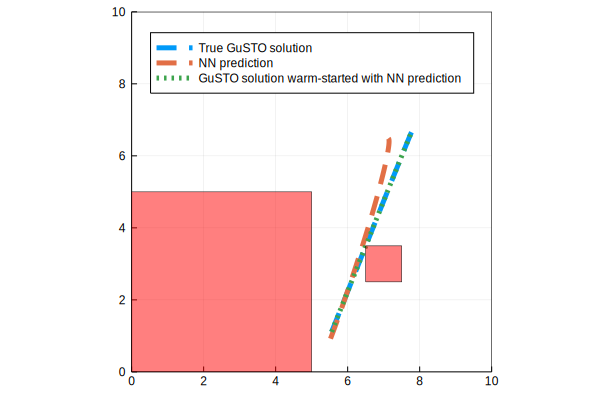

In [24]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 10.661724179 (11 iterations)
NN_solve_time = 0.013873346
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 5.613153331 (6 iterations)


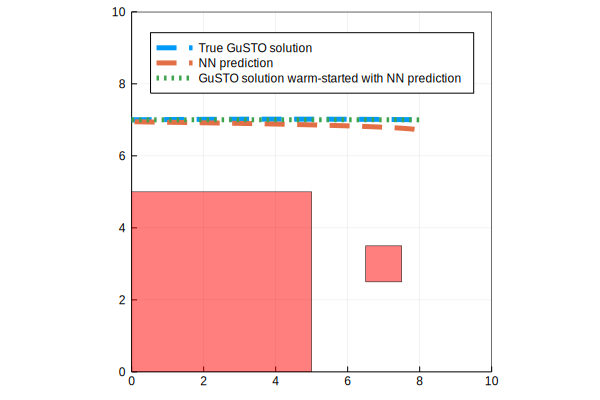

In [25]:
x_start= [0.0, 7.0, 0.5]
x_goal = [8.0, 7.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 10.848325741 (11 iterations)
NN_solve_time = 0.005012857
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 23.495602895 (21 iterations)


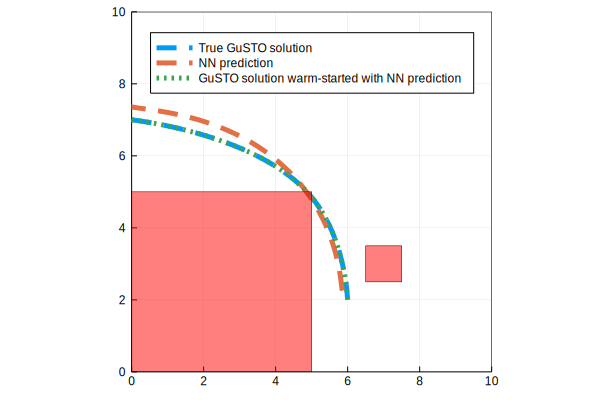

In [26]:
x_start= [0.0, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 8.858092488 (10 iterations)
NN_solve_time = 0.011465621
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 4.212461449 (5 iterations)


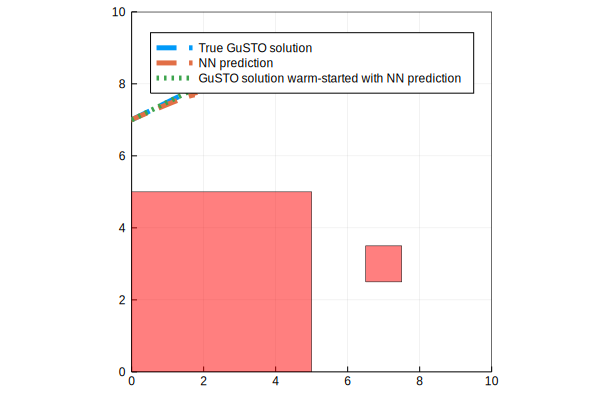

In [27]:
x_start= [0.0, 7.0, 0.5]
x_goal = [2.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

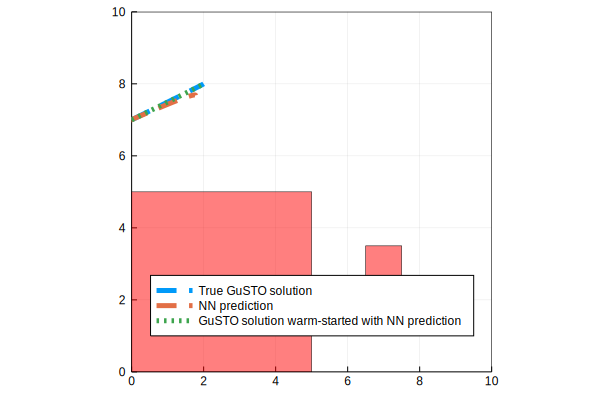

In [28]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:bottomright)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 4.132854036 (5 iterations)
NN_solve_time = 0.005173487
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 4.423070873 (5 iterations)


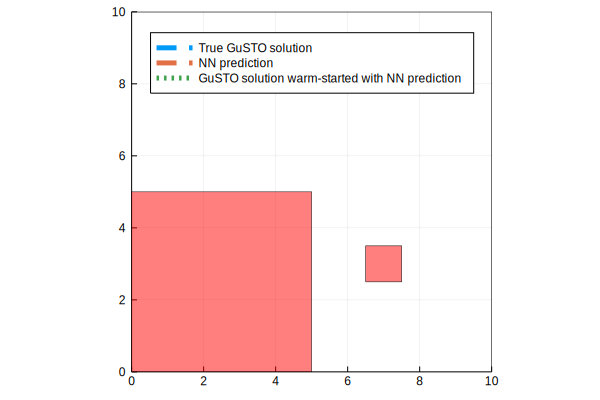

In [29]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 4.360098249 (5 iterations)
NN_solve_time = 0.0048052
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 5.259992408 (5 iterations)


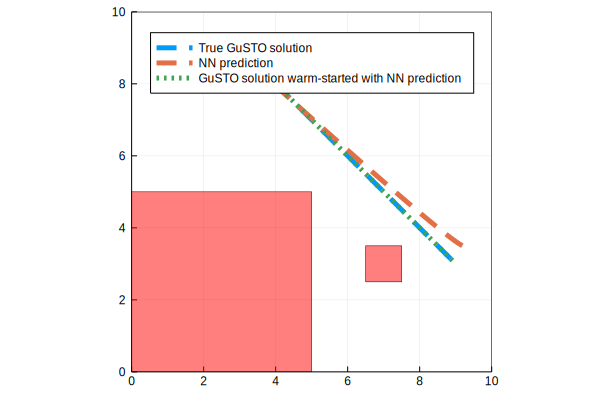

In [30]:
x_start= [4.0, 8.0, 0.5]
x_goal = [9.0, 3.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 7.073508403 (9 iterations)
NN_solve_time = 0.005662365
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 8.830222308 (10 iterations)


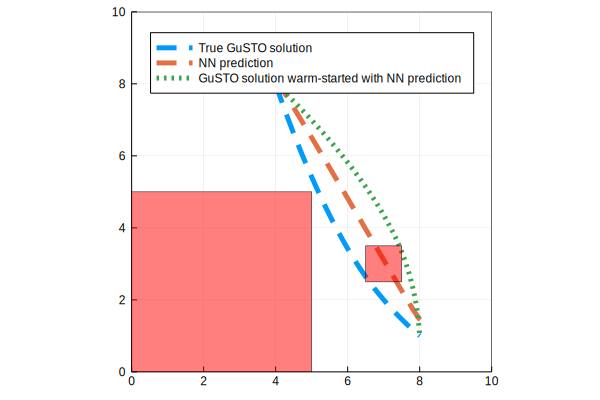

In [31]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 18.698676653 (18 iterations)
NN_solve_time = 0.005550304
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 14.798279416 (15 iterations)


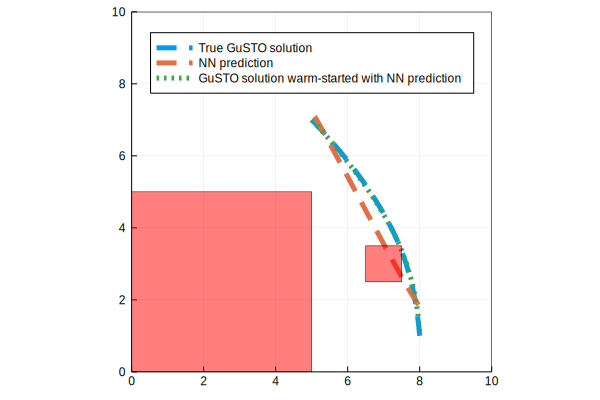

In [32]:
x_start= [5.0, 7.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 6.222605737 (7 iterations)
NN_solve_time = 0.007279008
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 13.685027075 (15 iterations)


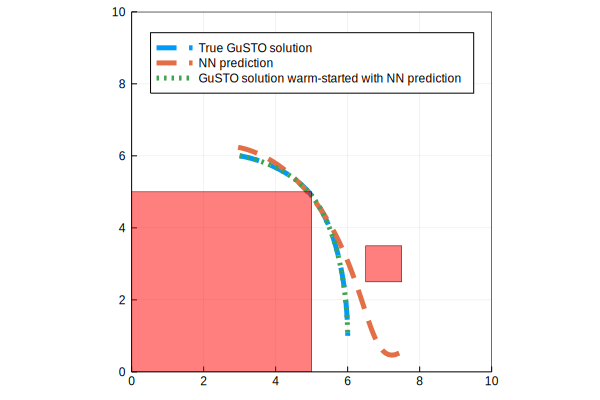

In [33]:
x_start= [3.0, 6.0, 0.5]
x_goal = [6.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 5.151047868 (6 iterations)
NN_solve_time = 0.011301056
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 10.319801035 (12 iterations)


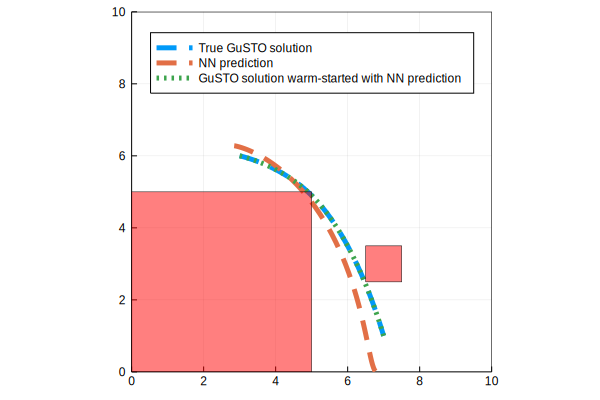

In [34]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 9.576298226 (11 iterations)
NN_solve_time = 0.008683547
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 6.09302791 (7 iterations)


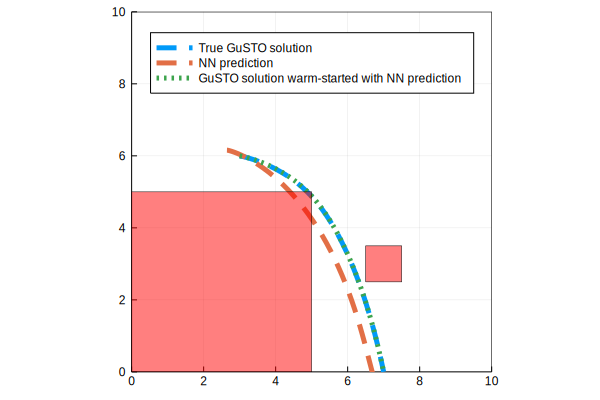

In [35]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 5.806406417 (7 iterations)
NN_solve_time = 0.011265451
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 6.221862681 (7 iterations)


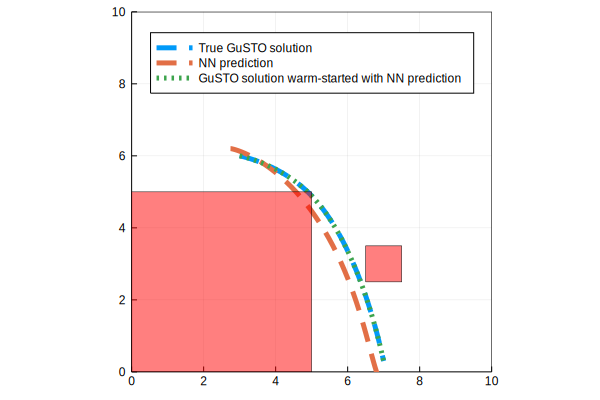

In [36]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 5.898263811 (7 iterations)
NN_solve_time = 0.006642486
Starting to solve GuSTO
Converged: true
GuSTO warm started solve time = 15.663915706 (15 iterations)


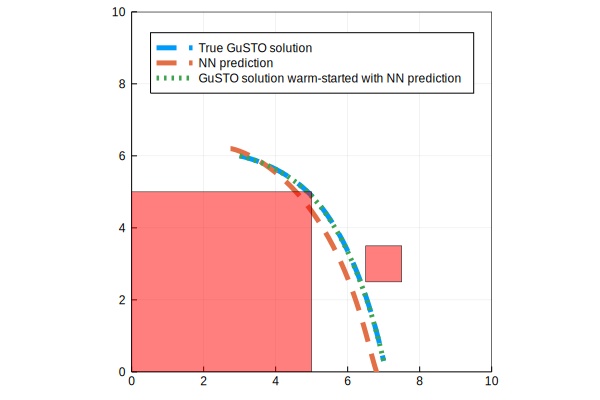

In [40]:
# Warm starting ONLY the X trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 7.561884266 (9 iterations)
NN_solve_time = 0.007922479
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 25.17022694 (26 iterations)


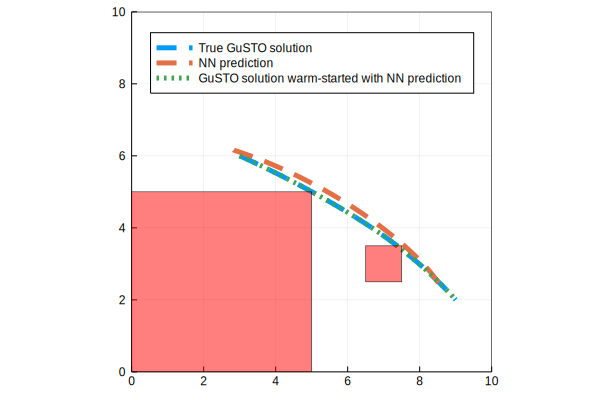

In [37]:
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 8.275595357 (9 iterations)
NN_solve_time = 0.004852655
Starting to solve GuSTO
Converged: true
GuSTO warm started solve time = 16.478488235 (17 iterations)


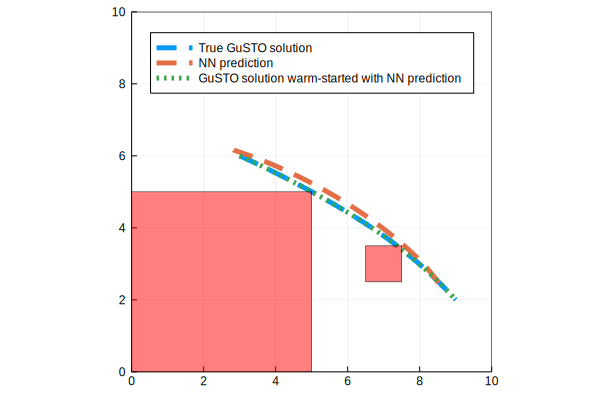

In [39]:
# Warm starting ONLY the x trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

Starting to solve GuSTO
Converged: true
GuSTO solve time = 21.424010674 (25 iterations)
NN_solve_time = 0.354211784
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 8.261796422 (10 iterations)


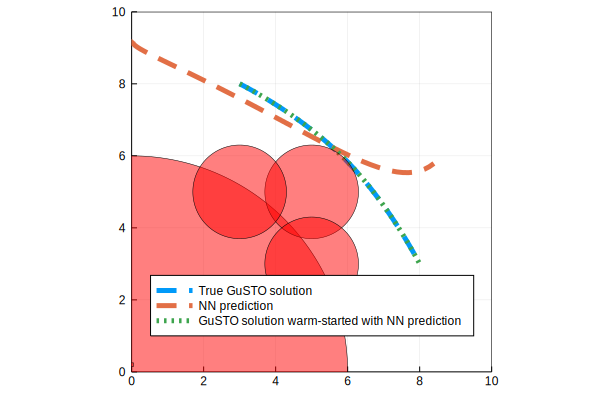

In [114]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 9.131828776 (10 iterations)
NN_solve_time = 0.005731816
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 55.22698583 (54 iterations)


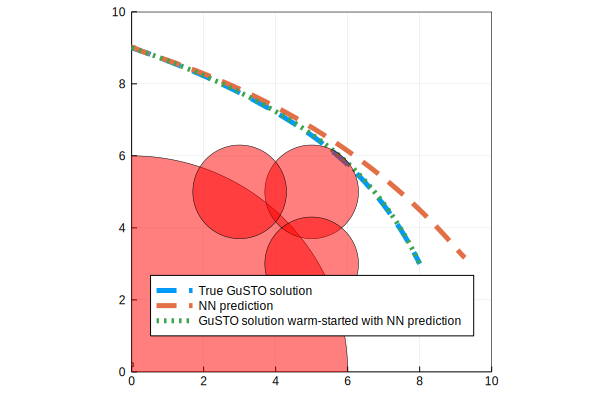

In [115]:
x_start= [0.0, 9.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


Starting to solve GuSTO
Converged: true
GuSTO solve time = 4.39845682 (5 iterations)
NN_solve_time = 0.026015397
Starting to solve GuSTO
GuSTO has been warm-started.
Converged: true
GuSTO warm started solve time = 5.237956385 (6 iterations)


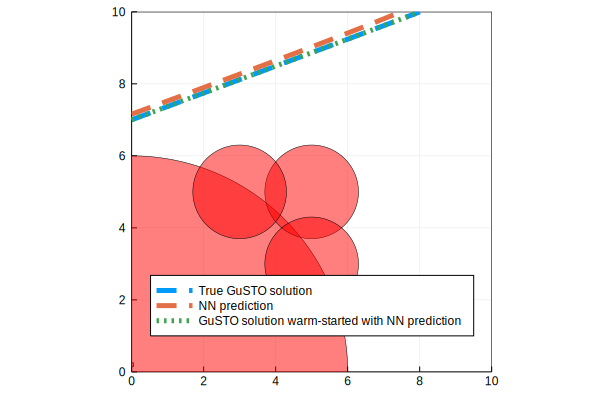

In [119]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 10.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Not implemented yet

In [ ]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    model = getModelWithCornerSpheres()
    

    
#     gusto_setup_time = (time_ns() - time_start)/10^9

#     times = []
    
#     time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end